In [1]:
import FlowCytometryTools as fct
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8

# Overview

FCS files contain an N x M matrix of event (cell) data and metadata, where N = number of events and M = number of attributes the cytometer gathers for each event, e.g. fluorescence, forward scatter, etc.

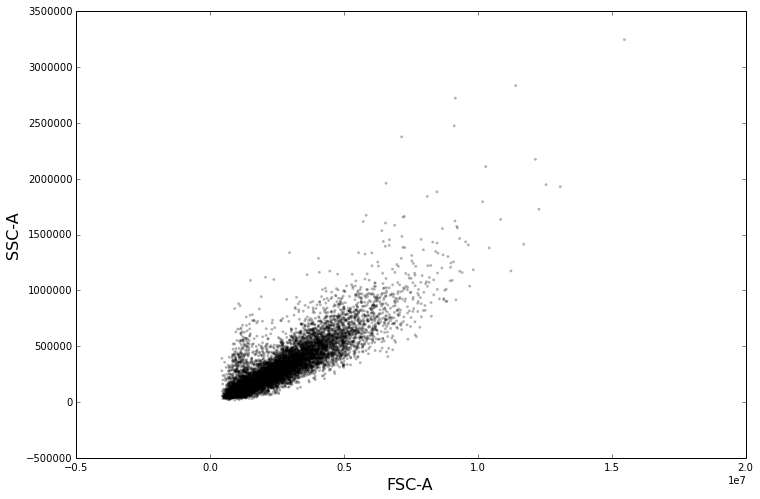

In [3]:
# The FlowCytometryTools package makes it easy to read in FCS files and
# extract + plot the event attributes.
sample = fct.FCMeasurement(ID='Test Sample', datafile='./Sample A03.fcs')
sample.plot(('FSC-A', 'SSC-A'), kind='scatter', color='black', alpha=0.3, s=8);

As you can see above, there are at least two distinct distributions of events - a large spray (this is 'normal'-ish yeast) and a small spray that's a little more vertical (this is likely tiny, but very reflective dead cells).

One of the most common ways to analyze cytometry data is to isolate a subset of events for downstream analysis, a process called gating. In our case, we want to isolate the 'normal' yeast from the dead yeast, because we normally want to analyze changes within a population.

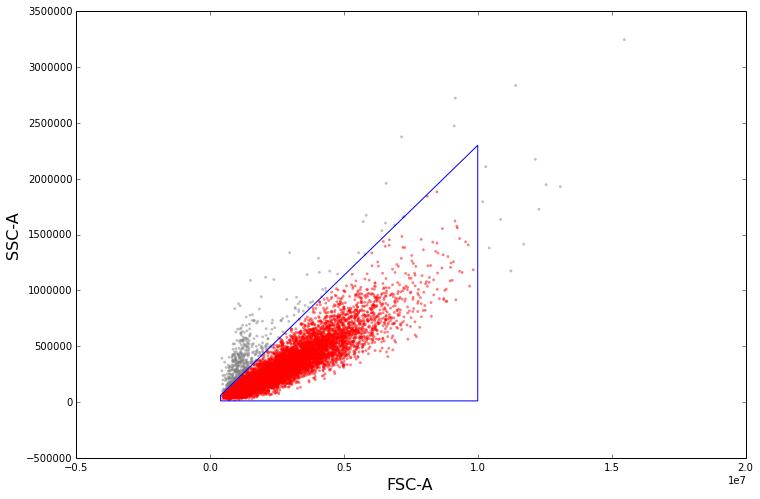

In [4]:
# A 2D Polygon Gate - just a set of vertices on the same attributes as above
yeast_gate = fct.PolyGate([(4e5, 1e4), (1e7, 1e4), (1e7, 23e5), (4e5, 6e4)], 
                          ('FSC-A', 'SSC-A'), 
                          region='in', 
                          name='poly gate')

# We can subset to the events within the gate, or to those outside of it
yeast_sample = sample.gate(yeast_gate)
notyeast_sample = sample.gate(~yeast_gate)

# A visualization of our new yeast_gate
yeast_sample.plot(('FSC-A', 'SSC-A'), gates=[yeast_gate], kind='scatter', color='red', alpha=0.5, s=8);
notyeast_sample.plot(('FSC-A', 'SSC-A'), kind='scatter', color='gray', alpha=0.5, s=8);

The code below demonstrates doublet discrimination - we can (mostly) isolate cells that are stuck together (dividing) from those that are free (not currently dividing) by comparing the 'height' and 'area' attributes of the forward scatter channel.

(0, 12000000.0)

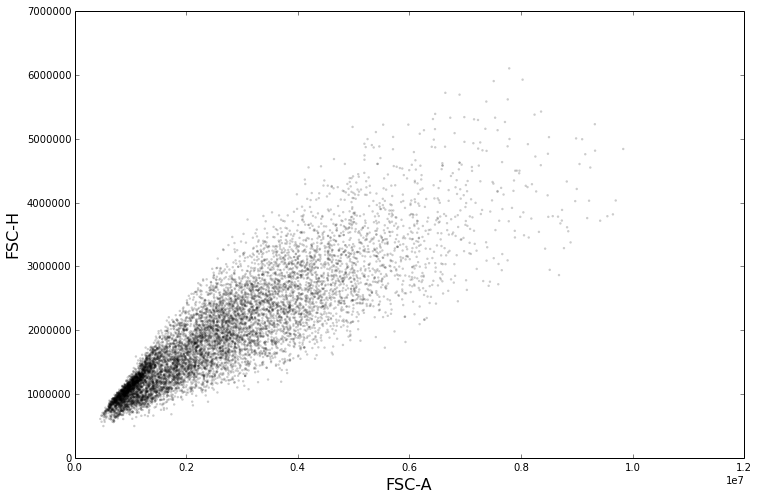

In [5]:
yeast_sample.plot(('FSC-A', 'FSC-H'), kind='scatter', color='black', alpha=0.2, s=6)
plt.ylim((0, 7e6))
plt.xlim((0, 1.2e7))

(0, 12000000.0)

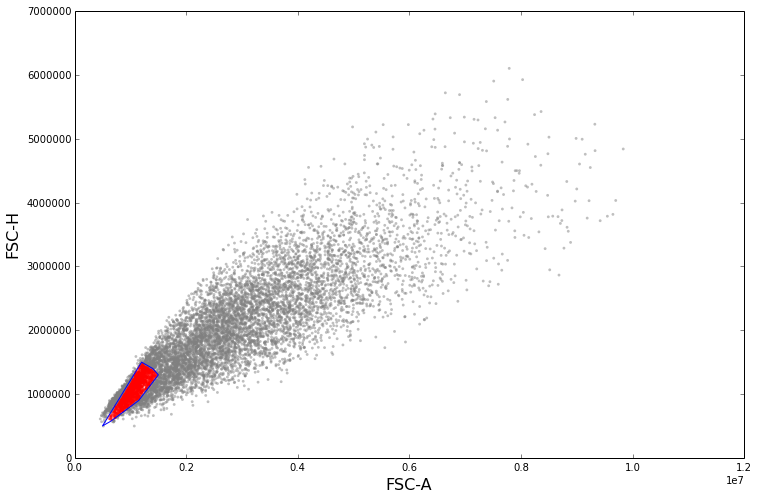

In [6]:
singlet_gate = fct.PolyGate([(6.5e5, 5.75e5), (1.15e6, 9e5), (1.5e6,1.3e6), (1.4e6, 1.4e6), (1.2e6, 1.5e6), (5e5, 5e5)], 
                            ('FSC-A', 'FSC-H'), 
                            region='in', 
                            name='singlets')

singlets_sample = yeast_sample.gate(singlet_gate)
notsinglets_sample = yeast_sample.gate(~singlet_gate)

singlets_sample.plot(('FSC-A', 'FSC-H'), gates=[singlet_gate], kind='scatter', color='red', alpha=0.5, s=8);
notsinglets_sample.plot(('FSC-A', 'FSC-H'), kind='scatter', color='gray', alpha=0.5, s=8);
plt.ylim((0, 7e6))
plt.xlim((0, 1.2e7))

There are many things we may want to know about our subpopulations - counts, fluorescence statistics, etc. These can be accessed using the gated FlowCytometryTools objects' attributes.

Number of yeast cells: 9545
Number of single cells: 1708
Mean: 3069.83548009
Median: 2919.0
Std Dev: 1589.52322858


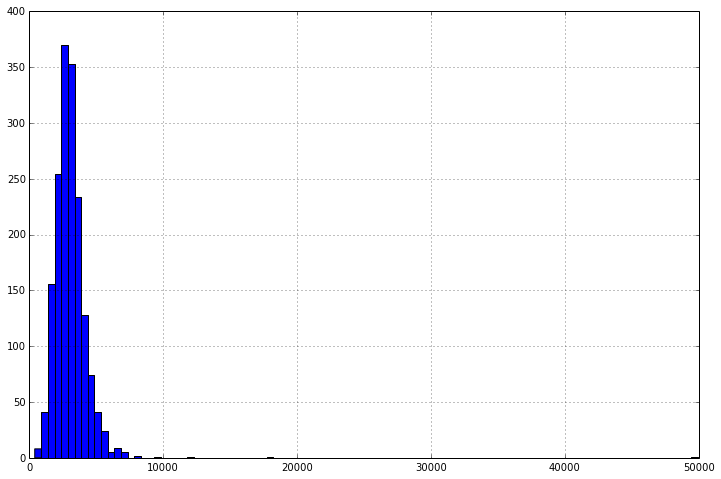

In [7]:
print 'Number of yeast cells:', yeast_sample.counts
print 'Number of single cells:', singlets_sample.counts

fl1a = singlets_sample['FL1-A']
print 'Mean:', fl1a.mean()
print 'Median:', fl1a.median()
print 'Std Dev:', fl1a.std()
fl1a.hist(bins=100)

In [8]:
# '$VOL' key stores the approximate volume taken up by the Accuri C6 in nanoliters
# microliters (ul) = nanoliters / 1000
ul = float(yeast_sample.meta['$VOL']) / 1000
print ul

14.541


# Analyzing concentrations

For the Killswitches, we care about analyzing concentrations. The code below is some of what Nick used to analyze the entire batch at once. You will want to focus in on just your strain (and the negative control).

In [17]:
# You can read in an entire 'plate' of FCS files at once, but you need to
# use a custom name parser
# The way that FCS files are parsed by default isn't compatible with
# the way C6 FCS files are named, so need a custom parser.
# Converts e.g. '/full/path/to/Sample C04.fcs' to 'C4'
import os
def parse_c6fcs(path):
    filename = os.path.basename(path)
    key_str = os.path.splitext(filename.strip('Sample '))[0]
    row = key_str[0]
    col = int(key_str[1:])
    return '{}{:01d}'.format(row, col)

# Note that I have placed all of the files in the /labw16/ folder, which anyone can read
plate1 = fct.FCPlate.from_dir(ID='plate1', path='/labw16/plate1/', parser=parse_c6fcs, position_mapper='name')

yeast_counts = plate1.gate(yeast_gate).counts()
yeast_counts

,1,2,3,4,5,6,7,8,9,10,11,12
A,10615,10162,10575,10548,10494,10504,10570,10531,78,NaN,NaN,NaN
B,10637,10566,10544,10506,10538,10530,10486,10403,513,NaN,NaN,NaN
C,10332,10326,10202,10254,10192,10325,10245,10117,122,NaN,NaN,NaN
D,10140,10093,10099,10077,10150,10122,10142,10091,18,NaN,NaN,NaN
E,10309,10294,10189,10113,10145,10172,10219,10144,32,NaN,NaN,NaN
F,10123,10096,10084,10062,10052,10040,10051,10196,132,NaN,NaN,NaN
G,10111,10098,10142,10149,10173,10134,10017,10088,1149,NaN,NaN,NaN
H,10249,10194,10181,10190,10167,10157,10105,10165,72,NaN,NaN,NaN


In [18]:
vol_list = plate1.get_measurement_metadata('$VOL')
concs = yeast_counts.copy()
for colname, value in vol_list.iteritems():
    row = colname[0]
    column = int(colname[1:])
    # Cytometer volume is in units of nanoliters
    ul_cyt = float(value) / 1000.0
    # Diluted sample 1:10 before reading
    ul = ul_cyt * 10
    concs.loc[row][column] = yeast_counts.loc[row][column] / ul
concs.columns = ['Strain {}'.format(col) for col in concs.columns]

concs

,Strain 1,Strain 2,Strain 3,Strain 4,Strain 5,Strain 6,Strain 7,Strain 8,Strain 9,Strain 10,Strain 11,Strain 12
A,486.480293,465.719523,440.441483,403.211009,400.840336,481.834862,606.077982,483.739090,0.155462,NaN,NaN,NaN
B,488.159706,484.901331,483.447960,482.147774,482.509158,439.115930,601.951780,595.477962,1.024893,NaN,NaN,NaN
C,278.115747,295.958727,274.542519,261.115355,291.867125,278.827977,276.518219,289.636416,0.243742,NaN,NaN,NaN
D,201.992032,256.688708,165.340537,230.700549,210.493571,221.052632,290.601719,220.231340,0.035964,NaN,NaN,NaN
E,472.673086,472.418541,576.953567,463.473877,465.366972,584.261918,425.969154,387.619412,0.063807,NaN,NaN,NaN
F,422.319566,355.743481,355.822159,271.652268,256.101911,219.213974,200.538707,424.302955,0.263731,NaN,NaN,NaN
G,243.814806,289.672978,202.354350,202.372881,245.309863,211.081025,169.779661,231.376147,2.290396,NaN,NaN,NaN
H,261.187564,259.455332,212.104167,245.957036,211.856637,221.671759,220.874317,222.234368,0.143529,NaN,NaN,NaN


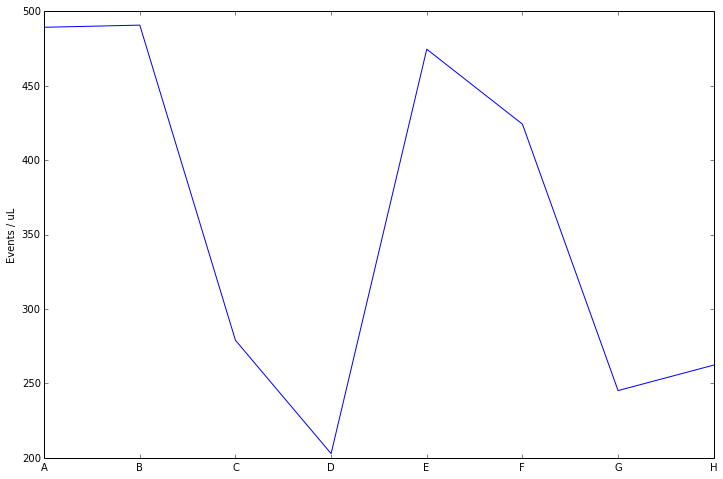

In [19]:
# Here I'm plotting just the negative control. The rest is up to you!
concs1.iloc[:,0].T.plot()
plt.ylabel('Events / uL');